# U5: Ejemplo de detección de arritmias con señales ECG

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/husseinlopez/cdsi2026/blob/main/U5_example-ecg.ipynb)

In [5]:
#!pip install wfdb heartpy scipy scikit-learn pandas numpy matplotlib seaborn

In [1]:
# system
import warnings
warnings.filterwarnings('ignore')

# data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ECG / signal
import wfdb
import heartpy as hp
from scipy.signal import welch
from scipy.interpolate import interp1d

# machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

### Datasets

Usamos dos bases de datos de PhysioNet, descargables directamente con `wfdb`:

- **MIT-BIH Arrhythmia Database** (`mitdb`): 48 registros de ECG ambulatorio de 30 minutos con anotaciones beat-by-beat de arritmias. 360 Hz. https://physionet.org/content/mitdb/1.0.0/
- **MIT-BIH Normal Sinus Rhythm Database** (`nsrdb`): 18 registros de sujetos sin arritmias significativas. 128 Hz. https://physionet.org/content/nsrdb/1.0.0/

La tarea de clasificación es **ritmo normal vs. arritmia**.

In [2]:
# MIT-BIH Arrhythmia: records with predominantly normal rhythm
# and records with clear arrhythmias — balanced subset for the example
ARRHYTHMIA_RECORDS = ['100', '101', '104', '105', '106',
                      '108', '109', '111', '112', '113']

# MIT-BIH Normal Sinus Rhythm
NORMAL_RECORDS     = ['16265', '16272', '16273', '16420', '16483',
                      '16539', '16773', '16786', '16795', '17052']

SR_ARRHYTHMIA = 360  # Hz
SR_NORMAL     = 128  # Hz

### Loading a single record

In [3]:
def load_record(record_id, db_name, sample_rate):
    """Download one record from PhysioNet and return the MLII channel + sample rate."""
    record = wfdb.rdrecord(record_id,
                           pn_dir=db_name,
                           sampfrom=0,
                           sampto=sample_rate * 60 * 10)  # first 10 minutes
    # use channel 0 (MLII) for all records
    ecg = record.p_signal[:, 0]
    return ecg

# load one arrhythmia record and one normal record
ecg_arr = load_record('106', 'mitdb', SR_ARRHYTHMIA)
ecg_nsr = load_record('16265', 'nsrdb', SR_NORMAL)

print(f'Arrhythmia record — samples: {len(ecg_arr)}, duration: {len(ecg_arr)/SR_ARRHYTHMIA/60:.1f} min')
print(f'Normal record     — samples: {len(ecg_nsr)}, duration: {len(ecg_nsr)/SR_NORMAL/60:.1f} min')

Arrhythmia record — samples: 216000, duration: 10.0 min
Normal record     — samples: 76800, duration: 10.0 min


## Exploratory analysis

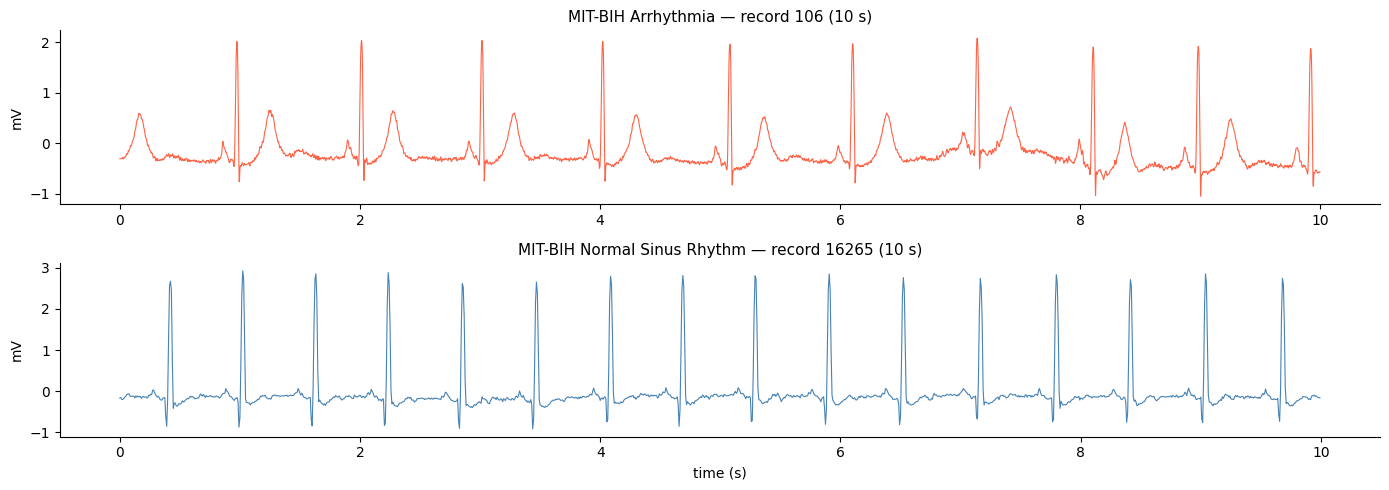

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 5), sharex=False)

# 10-second windows for visualization
t_arr = np.arange(10 * SR_ARRHYTHMIA) / SR_ARRHYTHMIA
t_nsr = np.arange(10 * SR_NORMAL) / SR_NORMAL

axes[0].plot(t_arr, ecg_arr[:10 * SR_ARRHYTHMIA], color='tomato', linewidth=0.8)
axes[0].set_title('MIT-BIH Arrhythmia — record 106 (10 s)', fontsize=11)
axes[0].set_ylabel('mV')

axes[1].plot(t_nsr, ecg_nsr[:10 * SR_NORMAL], color='steelblue', linewidth=0.8)
axes[1].set_title('MIT-BIH Normal Sinus Rhythm — record 16265 (10 s)', fontsize=11)
axes[1].set_ylabel('mV')
axes[1].set_xlabel('time (s)')

for ax in axes:
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

## Preprocessing

The two databases have different sampling rates (360 Hz vs 128 Hz). We resample all signals to a common rate before filtering and peak detection.

In [6]:
from scipy.signal import resample

TARGET_SR = 256  # common target sample rate (Hz)

def preprocess(ecg, original_sr, target_sr=TARGET_SR):
    """Resample to target_sr and apply bandpass filter."""
    # resample
    n_samples = int(len(ecg) * target_sr / original_sr)
    ecg_resampled = resample(ecg, n_samples)
    # bandpass filter 0.5–40 Hz
    ecg_filtered = hp.filter_signal(ecg_resampled,
                                    cutoff=[0.5, 40],
                                    sample_rate=target_sr,
                                    filtertype='bandpass')
    return ecg_filtered

ecg_arr_p = preprocess(ecg_arr, SR_ARRHYTHMIA)
ecg_nsr_p = preprocess(ecg_nsr, SR_NORMAL)

print(f'After preprocessing — arrhythmia: {len(ecg_arr_p)} samples')
print(f'After preprocessing — normal:     {len(ecg_nsr_p)} samples')

After preprocessing — arrhythmia: 153600 samples
After preprocessing — normal:     153600 samples


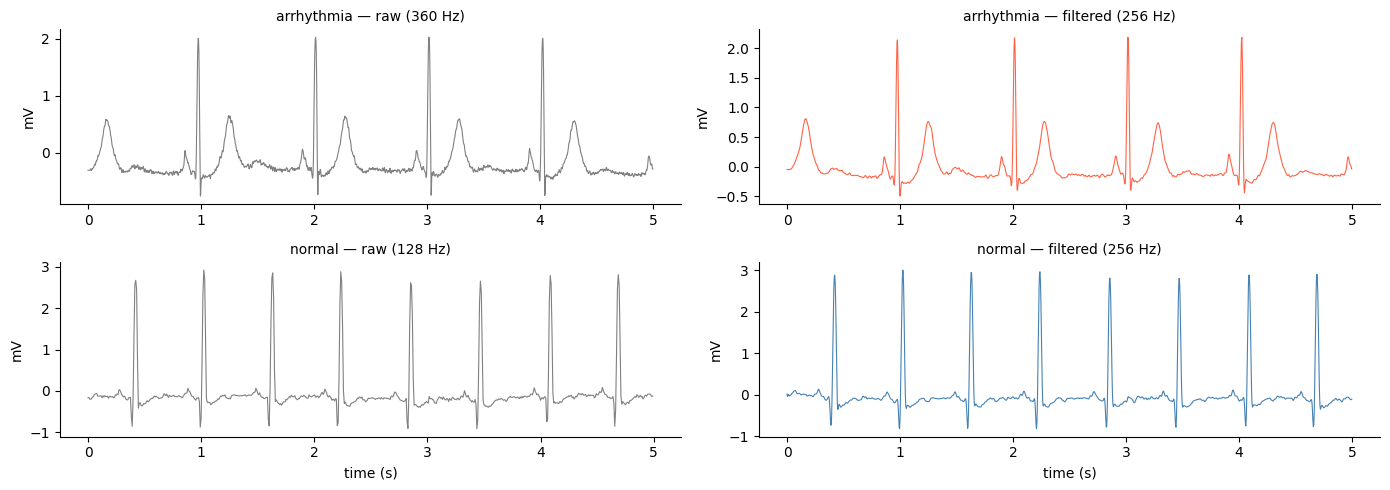

In [15]:
# show effect of preprocessing on 5-second window
n = 5 * TARGET_SR
t = np.arange(n) / TARGET_SR

# compute 5-second slices in each signal's original sample rate
n_arr_raw = 5 * SR_ARRHYTHMIA
n_nsr_raw = 5 * SR_NORMAL

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

axes[0, 0].plot(np.arange(n_arr_raw) / SR_ARRHYTHMIA, ecg_arr[:n_arr_raw], color='gray', linewidth=0.8)
axes[0, 0].set_title('arrhythmia — raw (360 Hz)', fontsize=10)
axes[0, 1].plot(t, ecg_arr_p[:n], color='tomato', linewidth=0.8)
axes[0, 1].set_title('arrhythmia — filtered (256 Hz)', fontsize=10)

axes[1, 0].plot(np.arange(n_nsr_raw) / SR_NORMAL, ecg_nsr[:n_nsr_raw], color='gray', linewidth=0.8)
axes[1, 0].set_title('normal — raw (128 Hz)', fontsize=10)
axes[1, 1].plot(t, ecg_nsr_p[:n], color='steelblue', linewidth=0.8)
axes[1, 1].set_title('normal — filtered (256 Hz)', fontsize=10)

for ax in axes.flatten():
    ax.set_ylabel('mV')
    sns.despine(ax=ax)

axes[1, 0].set_xlabel('time (s)')
axes[1, 1].set_xlabel('time (s)')

plt.tight_layout()
plt.show()

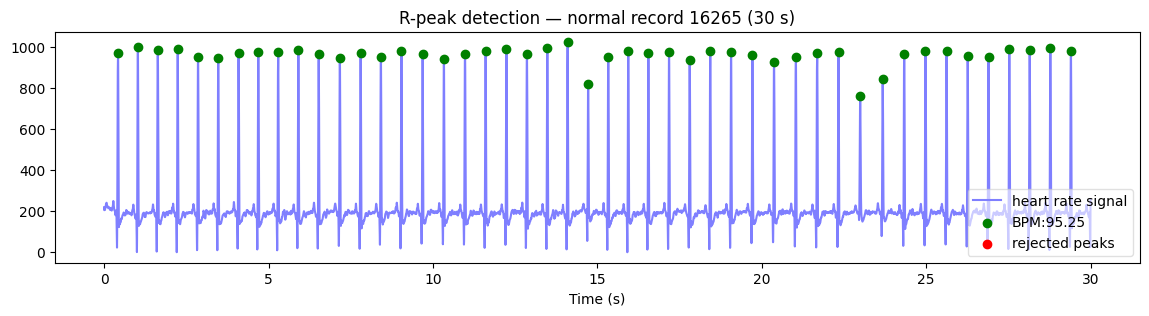

normal (16265):
  bpm: 95.2494
  ibi: 629.9253
  sdnn: 18.0930
  sdsd: 6.9585
  rmssd: 11.6753
  pnn20: 0.0667
  pnn50: 0.0000
  hr_mad: 15.6250
  sd1: 8.2474
  sd2: 24.1333
  s: 625.2975
  sd1/sd2: 0.3417
  breathingrate: 0.2763


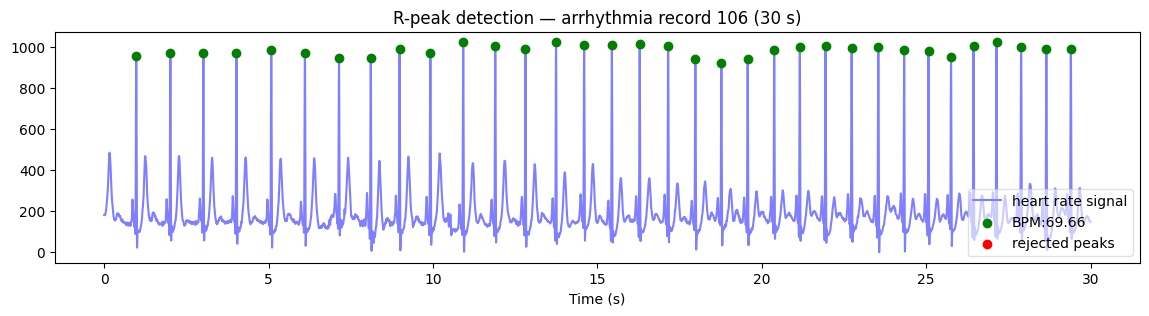

arrhythmia (106):
  bpm: 69.6647
  ibi: 861.2689
  sdnn: 110.4190
  sdsd: 23.8009
  rmssd: 39.2816
  pnn20: 0.5000
  pnn50: 0.2812
  hr_mad: 89.8438
  sd1: 27.0319
  sd2: 151.7039
  s: 12883.1779
  sd1/sd2: 0.1782
  breathingrate: 0.1760


In [18]:
# R-peak detection on a 30-second segment
for ecg_p, label, record in [
        (ecg_nsr_p, 'normal',     '16265'),
        (ecg_arr_p, 'arrhythmia', '106')]:
    segment = ecg_p[0 : 30 * TARGET_SR]
    try:
        wd, m = hp.process(hp.scale_data(segment), sample_rate=TARGET_SR)
        hp.plotter(wd, m,
                   title=f'R-peak detection — {label} record {record} (30 s)',
                   figsize=(14, 3))
        plt.show()
        print(f'{label} ({record}):')
        for k, v in m.items():
            print(f'  {k}: {v:.4f}')
    except Exception as e:
        print(f'{label} — processing error: {e}')

## Windowing

We divide each recording into fixed-length windows with 50% overlap. Each window will produce one feature vector.

A window of at least 30 seconds is needed to compute HRV reliably — it must contain enough R-peaks to estimate frequency-domain features after RR interpolation.

In [19]:
WINDOW_SEC  = 30
OVERLAP     = 0.5
WINDOW_SAMP = WINDOW_SEC * TARGET_SR
STEP_SAMP   = int(WINDOW_SAMP * (1 - OVERLAP))

def get_windows(ecg, window_samp=WINDOW_SAMP, step_samp=STEP_SAMP):
    """Slide a fixed window over the ECG signal."""
    windows = []
    for start in range(0, len(ecg) - window_samp, step_samp):
        windows.append(ecg[start : start + window_samp])
    return windows

wins_arr = get_windows(ecg_arr_p)
wins_nsr = get_windows(ecg_nsr_p)

print(f'Arrhythmia windows: {len(wins_arr)}')
print(f'Normal windows:     {len(wins_nsr)}')

Arrhythmia windows: 38
Normal windows:     38


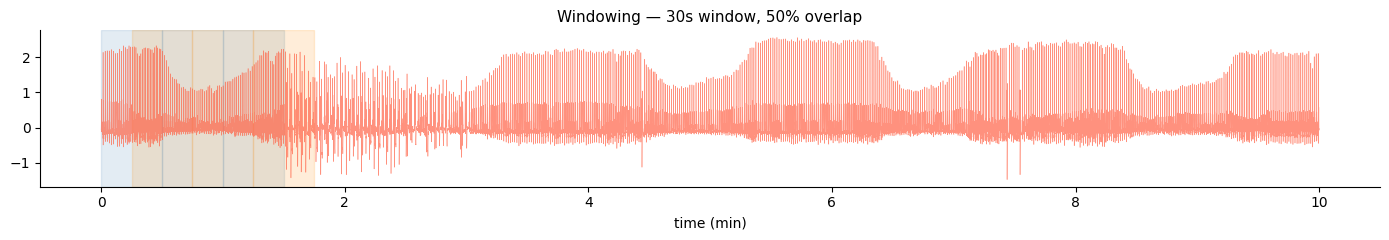

In [20]:
# illustrate the windowing scheme
fig, ax = plt.subplots(figsize=(14, 2.5))
t_full = np.arange(len(ecg_arr_p)) / TARGET_SR / 60

ax.plot(t_full, ecg_arr_p, color='tomato', linewidth=0.4, alpha=0.7)

# draw first 6 window borders
colors_w = ['steelblue', 'darkorange']
for i in range(min(6, len(wins_arr))):
    x0 = i * STEP_SAMP / TARGET_SR / 60
    x1 = (i * STEP_SAMP + WINDOW_SAMP) / TARGET_SR / 60
    ax.axvspan(x0, x1, alpha=0.15, color=colors_w[i % 2])

ax.set_xlabel('time (min)')
ax.set_title(f'Windowing — {WINDOW_SEC}s window, {int(OVERLAP*100)}% overlap', fontsize=11)
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

## Feature extraction

### Time-domain features

In [21]:
def extract_time_domain(rr_intervals):
    """
    rr_intervals: RR intervals in milliseconds.
    Returns SDNN, RMSSD, pNN50, mean HR, mean RR.
    """
    if len(rr_intervals) < 5:
        return None
    rr   = np.array(rr_intervals)
    diff = np.diff(rr)
    return {
        'mean_rr' : np.mean(rr),
        'sdnn'    : np.std(rr),
        'rmssd'   : np.sqrt(np.mean(diff ** 2)),
        'pnn50'   : np.sum(np.abs(diff) > 50) / len(diff) * 100,
        'mean_hr' : 60000 / np.mean(rr),
    }

### Frequency-domain features

The RR series is interpolated to a uniform grid and the Power Spectral Density is estimated with Welch's method. We integrate in the standard HRV bands:
- **LF** (0.04–0.15 Hz): combined sympathetic and parasympathetic activity
- **HF** (0.15–0.4 Hz): parasympathetic activity / respiratory sinus arrhythmia
- **LF/HF ratio**: autonomic balance index — increases under stress or arrhythmia

In [22]:
def extract_frequency_domain(rr_intervals, fs_interp=4.0):
    """
    Interpolates the RR series and computes PSD-based HRV bands.
    fs_interp: resampling frequency (Hz). Standard for HRV is 4 Hz.
    """
    if len(rr_intervals) < 10:
        return None
    rr   = np.array(rr_intervals)
    t_rr = np.cumsum(rr) / 1000.0
    t_rr -= t_rr[0]

    t_uniform = np.arange(t_rr[0], t_rr[-1], 1.0 / fs_interp)
    if len(t_uniform) < 16:
        return None

    interp_fn  = interp1d(t_rr, rr, kind='cubic', fill_value='extrapolate')
    rr_uniform = interp_fn(t_uniform)

    freqs, psd = welch(rr_uniform, fs=fs_interp,
                       nperseg=min(256, len(rr_uniform)))

    def band_power(f_lo, f_hi):
        idx = (freqs >= f_lo) & (freqs < f_hi)
        return np.trapz(psd[idx], freqs[idx])

    vlf   = band_power(0.003, 0.04)
    lf    = band_power(0.04,  0.15)
    hf    = band_power(0.15,  0.40)
    total = vlf + lf + hf

    return {
        'lf_power'    : lf,
        'hf_power'    : hf,
        'lf_hf_ratio' : lf / hf if hf > 0 else 0,
        'lf_norm'     : lf / (total - vlf) * 100 if (total - vlf) > 0 else 0,
        'hf_norm'     : hf / (total - vlf) * 100 if (total - vlf) > 0 else 0,
    }

### Non-linear features (Poincaré plot)

The Poincaré plot maps each RR interval against the next one. SD1 reflects short-term (beat-to-beat) variability driven by the parasympathetic system. SD2 reflects longer-term variability.

In [23]:
def extract_nonlinear(rr_intervals):
    """SD1, SD2 and SD2/SD1 ratio from the Poincaré plot."""
    if len(rr_intervals) < 5:
        return None
    rr  = np.array(rr_intervals)
    rr1 = rr[:-1]
    rr2 = rr[1:]
    sd1 = np.std((rr2 - rr1) / np.sqrt(2))
    sd2 = np.std((rr2 + rr1) / np.sqrt(2))
    return {
        'sd1'     : sd1,
        'sd2'     : sd2,
        'sd2_sd1' : sd2 / sd1 if sd1 > 0 else 0,
    }

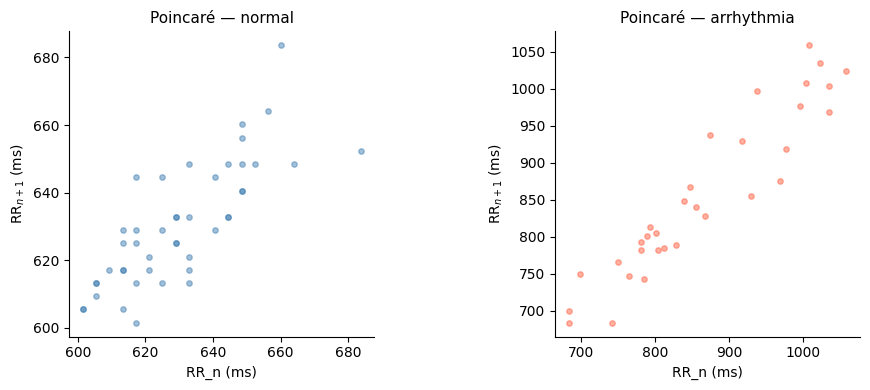

In [24]:
# visualize Poincare plot for both conditions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (wins, label, color) in zip(axes, [
        (wins_nsr, 'normal',     'steelblue'),
        (wins_arr, 'arrhythmia', 'tomato')]):
    # use first window that processes cleanly
    for win in wins:
        try:
            wd, _ = hp.process(hp.scale_data(win), sample_rate=TARGET_SR)
            rr = np.array(wd['RR_list_cor'])
            if len(rr) > 10:
                ax.scatter(rr[:-1], rr[1:], alpha=0.5, s=15, color=color)
                ax.set_title(f'Poincaré — {label}', fontsize=11)
                ax.set_xlabel('RR_n (ms)')
                ax.set_ylabel('RR$_{n+1}$ (ms)')
                ax.set_aspect('equal')
                sns.despine(ax=ax)
                break
        except:
            continue

plt.tight_layout()
plt.show()

### Building the feature vector

In [25]:
def extract_all_features(ecg_window, sample_rate=TARGET_SR):
    """Run HeartPy on one window and combine all three feature domains."""
    try:
        wd, m = hp.process(hp.scale_data(ecg_window),
                           sample_rate=sample_rate,
                           clean_rr=True)
        rr = np.array(wd['RR_list_cor'])
        if len(rr) < 10:
            return None
        td = extract_time_domain(rr)
        fd = extract_frequency_domain(rr)
        nl = extract_nonlinear(rr)
        if any(d is None for d in [td, fd, nl]):
            return None
        return {**td, **fd, **nl}
    except:
        return None

In [26]:
# build feature vector for the two loaded records
records = []
for wins, label, subj in [(wins_nsr, 'normal', '16265'),
                           (wins_arr, 'arrhythmia', '106')]:
    for win in wins:
        feats = extract_all_features(win)
        if feats is not None:
            feats['label']   = label
            feats['subject'] = subj
            records.append(feats)

df_single = pd.DataFrame(records)
print(df_single['label'].value_counts())
df_single.head()

label
normal        38
arrhythmia    36
Name: count, dtype: int64


,mean_rr,sdnn,rmssd,pnn50,mean_hr,lf_power,hf_power,lf_hf_ratio,lf_norm,hf_norm,sd1,sd2,sd2_sd1,label,subject
0,629.925272,18.093017,11.675267,0.0,95.249393,96.967588,31.713388,3.057623,75.355030,24.644970,8.247441,24.133350,2.926162,normal,16265
1,637.143342,14.438389,10.753033,0.0,94.170332,69.260162,18.247601,3.795576,79.147449,20.852551,7.591393,18.583689,2.447995,normal,16265
2,629.585598,18.090626,11.529137,0.0,95.300782,110.167058,47.604226,2.314229,69.827066,30.172934,8.148633,24.245337,2.975387,normal,16265
3,622.174202,17.500885,11.943053,0.0,96.436014,91.159815,46.134061,1.975976,66.397583,33.602417,8.403069,22.641884,2.694478,normal,16265
4,600.924745,30.629471,11.893767,0.0,99.846113,78.505274,27.095364,2.897369,74.341666,25.658334,8.409966,42.894357,5.100420,normal,16265


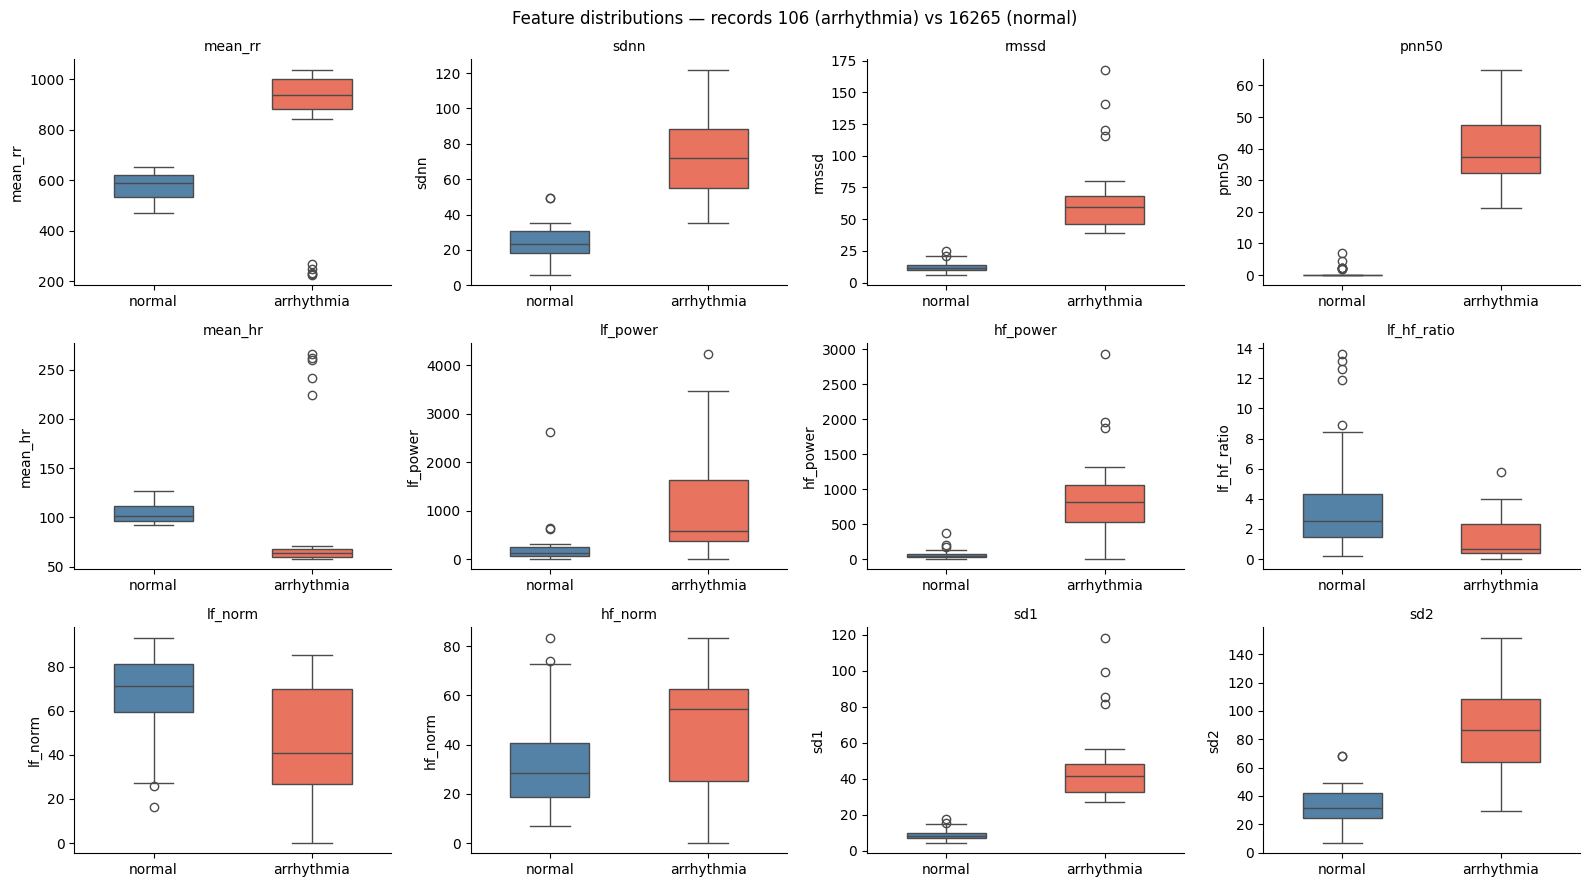

In [27]:
# compare feature distributions between conditions
feature_cols = [c for c in df_single.columns if c not in ['label', 'subject']]

fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

palette = {'normal': 'steelblue', 'arrhythmia': 'tomato'}

for ax, feat in zip(axes, feature_cols):
    sns.boxplot(data=df_single, x='label', y=feat,
                palette=palette, ax=ax, width=0.5)
    ax.set_title(feat, fontsize=10)
    ax.set_xlabel('')
    sns.despine(ax=ax)

for ax in axes[len(feature_cols):]:
    ax.set_visible(False)

plt.suptitle('Feature distributions — records 106 (arrhythmia) vs 16265 (normal)',
             fontsize=12)
plt.tight_layout()
plt.show()

## Multi-record feature vector

We repeat the pipeline for all selected records to build a dataset with enough subjects for Leave-One-Subject-Out evaluation.

In [28]:
all_records = []

record_list = (
    [(rec, 'mitdb',  SR_ARRHYTHMIA, 'arrhythmia') for rec in ARRHYTHMIA_RECORDS] +
    [(rec, 'nsrdb',  SR_NORMAL,     'normal')      for rec in NORMAL_RECORDS]
)

for rec_id, db, sr, label in record_list:
    try:
        ecg   = load_record(rec_id, db, sr)
        ecg_p = preprocess(ecg, sr)
        wins  = get_windows(ecg_p)
        n_ok  = 0
        for win in wins:
            feats = extract_all_features(win)
            if feats is not None:
                feats['label']   = label
                feats['subject'] = rec_id
                all_records.append(feats)
                n_ok += 1
        print(f'{rec_id:6s} ({label:11s}): {n_ok} windows')
    except Exception as e:
        print(f'{rec_id:6s}: skipped ({e})')

df_all = pd.DataFrame(all_records)
print(f'\nTotal: {len(df_all)} windows — {df_all["subject"].nunique()} subjects')
df_all.head()

100    (arrhythmia ): 38 windows
101    (arrhythmia ): 37 windows
104    (arrhythmia ): 35 windows
105    (arrhythmia ): 38 windows
106    (arrhythmia ): 36 windows
108    (arrhythmia ): 29 windows
109    (arrhythmia ): 38 windows
111    (arrhythmia ): 21 windows
112    (arrhythmia ): 38 windows
113    (arrhythmia ): 27 windows
16265  (normal     ): 38 windows
16272  (normal     ): 37 windows
16273  (normal     ): 38 windows
16420  (normal     ): 38 windows
16483  (normal     ): 38 windows
16539  (normal     ): 38 windows
16773  (normal     ): 38 windows
16786  (normal     ): 38 windows
16795  (normal     ): 15 windows
17052  (normal     ): 38 windows

Total: 693 windows — 20 subjects


,mean_rr,sdnn,rmssd,pnn50,mean_hr,lf_power,hf_power,lf_hf_ratio,lf_norm,hf_norm,sd1,sd2,sd2_sd1,label,subject
0,815.602022,39.811065,52.973862,12.121212,73.565291,104.534933,263.827023,0.396225,28.378320,71.621680,37.446860,42.587653,1.137282,arrhythmia,100
1,814.019097,25.486893,29.343341,5.714286,73.708344,59.180394,294.893282,0.200684,16.714147,83.285853,20.748725,29.571049,1.425198,arrhythmia,100
2,812.391493,24.035452,26.427572,5.714286,73.856017,53.968589,183.282330,0.294456,22.747473,77.252527,18.684449,28.892457,1.546337,arrhythmia,100
3,809.244792,24.176360,25.133919,2.857143,74.143202,87.629945,216.335345,0.405065,28.828931,71.171069,17.763777,29.390423,1.654514,arrhythmia,100
4,809.895833,22.627796,22.939273,0.000000,74.083601,53.684068,250.486065,0.214320,17.649356,82.350644,16.218787,27.645700,1.704548,arrhythmia,100


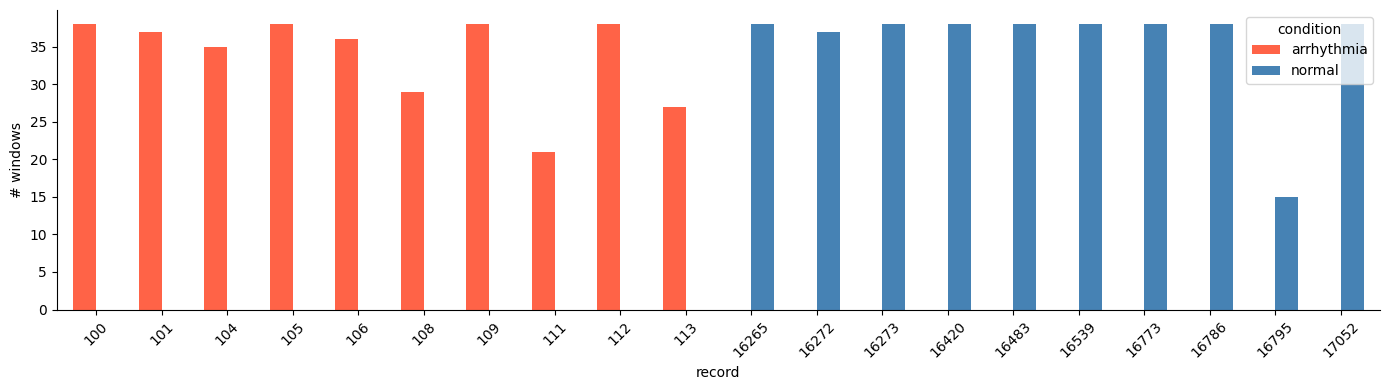

In [29]:
# class balance per subject
pivot = df_all.groupby(['subject', 'label']).size().unstack(fill_value=0)
pivot.plot(kind='bar', figsize=(14, 4),
           color=['tomato', 'steelblue'], width=0.7)
plt.ylabel('# windows')
plt.xlabel('record')
plt.xticks(rotation=45)
plt.legend(title='condition')
sns.despine()
plt.tight_layout()
plt.show()

## Classification

### Leave-One-Subject-Out (LOSO) evaluation

In previous units we split data randomly into train/test. For physiological data this is problematic: if windows from the same subject appear in both sets, the model learns individual ECG morphology rather than generalizable patterns — inflating accuracy artificially.

Leave-One-Subject-Out (LOSO) is a stricter protocol: on each fold one subject is held out entirely as the test set. This simulates deploying the model on a new, unseen person — a much more realistic evaluation.

In [31]:
feature_cols = [c for c in df_all.columns if c not in ['label', 'subject']]

le = LabelEncoder()
X      = df_all[feature_cols].values
y      = le.fit_transform(df_all['label'].values)
groups = df_all['subject'].values

logo = LeaveOneGroupOut()

classifiers = {
    'Decision Tree' : DecisionTreeClassifier(random_state=42),
    'kNN'           : KNeighborsClassifier(n_neighbors=5),
    'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {name: {'y_true': [], 'y_pred': []} for name in classifiers}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler  = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        results[name]['y_true'].extend(y_test)
        results[name]['y_pred'].extend(pred)

for name in classifiers:
    y_true = np.array(results[name]['y_true'])
    y_pred = np.array(results[name]['y_pred'])
    f1  = f1_score(y_true, y_pred, average='macro')
    print(f'{name:20s}  F1 (macro): {f1:.3f}')

Decision Tree         F1 (macro): 0.782
kNN                   F1 (macro): 0.796
Random Forest         F1 (macro): 0.763


### Confusion matrices

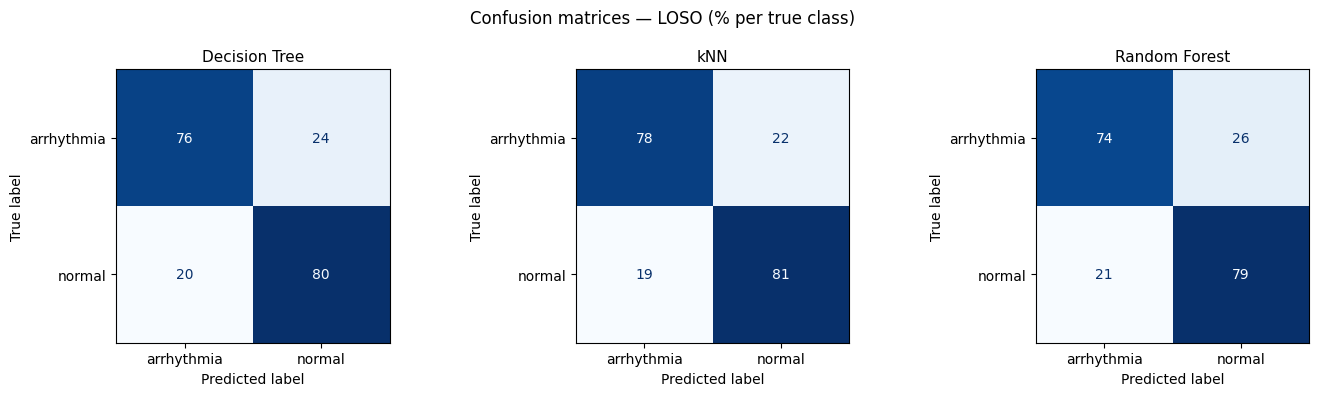

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
class_names = le.classes_

for ax, name in zip(axes, classifiers):
    cm = confusion_matrix(results[name]['y_true'],
                          results[name]['y_pred'])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=class_names)
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(name, fontsize=11)

plt.suptitle('Confusion matrices — LOSO (% per true class)', fontsize=12)
plt.tight_layout()
plt.show()

### Feature importance (Random Forest)

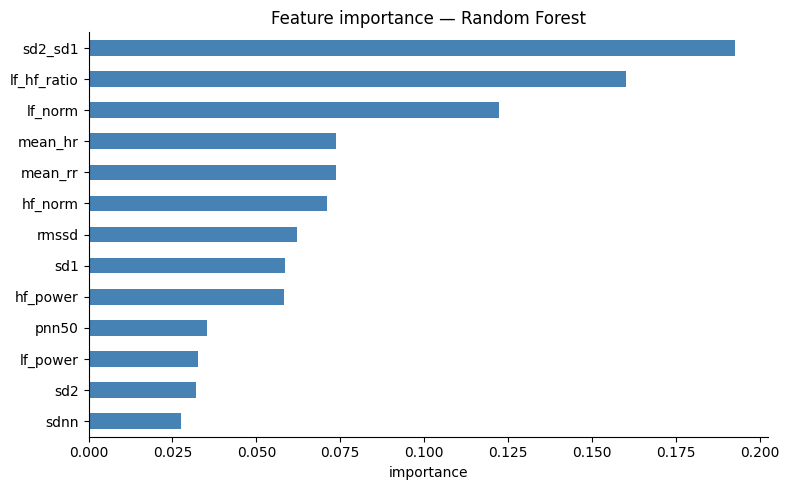

In [33]:
# refit on all data for stable importances
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)
classifiers['Random Forest'].fit(X_scaled, y)

importances = pd.Series(
    classifiers['Random Forest'].feature_importances_,
    index=feature_cols
).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='steelblue')
plt.xlabel('importance')
plt.title('Feature importance — Random Forest')
sns.despine()
plt.tight_layout()
plt.show()